In [12]:
import rosbag
import numpy as np
from std_msgs.msg import Int32, String
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import rosbag_pandas
import yaml

import warnings
import re
import subprocess
import types

import pandas as pd
import numpy as np

import rospy

%matplotlib notebook
plt.close("all")

In [2]:
#hard coded function of if statements to get out data we want from bag file
def bag2var(bag, topic):
    
    #create all potential empty lists
    
    #vicon
    positions_vicon = []
    orientations_vicon = []
    times_vicon = []
    
    #robot joint_states
    positions_joints = []
    torques_joints = []
    times_joints = []
    
    #trajectory timing flag
    status_traj = []
    status_times_traj = []
    
    #self defined cycle flag
    cycle_bools = []   
    cycle_times = []
    
    #iterate through, and fill vars based on topic name passed
    for topic, msg, t, in bag.read_messages(topics = [topic]):
        if '/tf' in topic:
            #/tf
            pos = np.array([msg.transforms[0].transform.translation.x, msg.transforms[0].transform.translation.y,
                           msg.transforms[0].transform.translation.z])
            rot = np.array([msg.transforms[0].transform.rotation.w, msg.transforms[0].transform.rotation.x,
                           msg.transforms[0].transform.rotation.y, msg.transforms[0].transform.rotation.z])
            time = msg.transforms[0].header.stamp.to_sec()
            
            frame_id = msg.transforms[0].child_frame_id
            
            if 'j1_dim/base_link' in frame_id:            
                translations_tf_j1.append(pos)
                rotations_tf_j1.append(rot)
                times_tf_j1.append(time)
                
                            
            if 'j2_dim/base_link' in frame_id:            
                translations_tf_j2.append(pos)
                rotations_tf_j2.append(rot)
                times_tf_j2.append(time)
                
                            
            if 'j3_dim/base_link' in frame_id:            
                translations_tf_j3.append(pos)
                rotations_tf_j3.append(rot)
                times_tf_j3.append(time)
            
                           
        if '/vicon/' in topic:
            #/vicon
            pos = np.array([msg.pose.position.x, msg.pose.position.y, msg.pose.position.z])
            rot = np.array([msg.pose.orientation.w, msg.pose.orientation.x, msg.pose.orientation.y, 
                            msg.pose.orientation.z])
            time = msg.header.stamp.to_sec()
            
            positions_vicon.append(pos)
            orientations_vicon.append(rot)
            times_vicon.append(time)
                           
        if '/robot/joint_states' in topic:
            #/joint_states
            if len(msg.name) > 2:  #heuristic to know that we're not getting fingers
                pos = np.array([msg.position])
                torq = np.array([msg.effort])
                time = msg.header.stamp.to_sec()

                positions_joints.append(pos)
                torques_joints.append(torq)
                times_joints.append(time)
                           
        if '/follow_joint_trajectory/status' in topic:
            #/status
            if len(msg.status_list) == 0:
                status_traj.append(0)
            else:
                status = msg.status_list[0].status
                status_traj.append(status)
            status_times_traj.append(msg.header.stamp.to_sec())
                           
        if '/board_pose/cycle_on' in topic:
            #/cycle_on bool
            cycle_bools.append(msg.data)
            
        if '/board_pose/cycle_time' in topic:
            #/cycle_time
            cycle_times.append(msg.data.to_sec())
            
    if '/tf' in topic:
        print "Returning translations, rotations, and timestamps for j1/2/3"
        return (translations_tf_j1, translations_tf_j2, translations_tf_j3, 
                rotations_tf_j1, rotations_tf_j2, rotations_tf_j3,
                times_tf_j1, times_tf_j2, times_tf_j3)
    if '/vicon/' in topic:
        #/vicon
        print "Returning positions, orientations, and timestamps for specified vicon rigid body"
        return (list(np.array(positions_vicon).squeeze()), 
                list(np.array(orientations_vicon).squeeze()), 
                list(np.array(times_vicon).squeeze())
               )
    if '/robot/joint_states' in topic:
        #/joint_states
        print "Returning positions and torques of all joints, indexed in order (see Baxter Wiki)"
        return positions_joints, torques_joints, times_joints
    if '/follow_joint_trajectory/status' in topic:
        #/status
        print "Returning trajectory status list with timestamps"
        return status_traj, status_times_traj
    if '/board_pose/cycle_on' in topic:
        #/cycle_on bool
        print "Returning cycle on/off flags"
        return cycle_bools
    if '/board_pose/cycle_time' in topic:
        #/cycle_time
        print "Returning cycle on/off times"
        return cycle_times

In [3]:
def allVarsDict(bag, bag_key, create_dicts=False):
    """
    Input:   bag - rosbag Bag object
             bag_key - key for dictionary 
             
    Output:  Nothing
    
    Functionality: Calls bag2var function for each topic we want and puts them in corresponding dictionaries 
    """
    if create_dicts:
#         global j1_pos, j1_rot, j1_time 
#         global j2_pos, j2_rot, j2_time 
#         global j3_pos, j3_rot, j3_time 
        global vicon_pos, vicon_rot, vicon_time
        global joint_angles, joint_torques, joint_times 
        global traj_status, traj_time 
        global cycle_on, cycle_time 
        
        vicon_pos, vicon_rot, vicon_time = {}, {}, {}
#         j1_pos, j1_rot, j1_time = {},{},{}
#         j2_pos, j2_rot, j2_time = {},{},{}
#         j3_pos, j3_rot, j3_time = {},{},{}
        joint_angles, joint_torques, joint_times = {},{},{}
        traj_status, traj_time = {},{}
        cycle_on, cycle_time = {},{}
            
    vicon_pos[bag_key] = {}
    vicon_rot[bag_key] = {}
    vicon_time[bag_key] = {}
    
    print 'getting vicon data...'
    vicon_pos[bag_key]['j1'], vicon_rot[bag_key]['j1'], vicon_time[bag_key]['j1'] = bag2var(bag, '/vicon/j1_dim/pose')
    vicon_pos[bag_key]['j2'], vicon_rot[bag_key]['j2'], vicon_time[bag_key]['j2'] = bag2var(bag, '/vicon/j2_dim/pose')
    vicon_pos[bag_key]['j3'], vicon_rot[bag_key]['j3'], vicon_time[bag_key]['j3'] = bag2var(bag, '/vicon/j3_dim/pose')
    vicon_pos[bag_key]['j4'], vicon_rot[bag_key]['j4'], vicon_time[bag_key]['j4'] = bag2var(bag, '/vicon/j4_dim/pose')
    vicon_pos[bag_key]['j5'], vicon_rot[bag_key]['j5'], vicon_time[bag_key]['j5'] = bag2var(bag, '/vicon/j5_dim/pose')
    vicon_pos[bag_key]['j6'], vicon_rot[bag_key]['j6'], vicon_time[bag_key]['j6'] = bag2var(bag, '/vicon/j6_dim/pose')
    vicon_pos[bag_key]['j7'], vicon_rot[bag_key]['j7'], vicon_time[bag_key]['j7'] = bag2var(bag, '/vicon/j7_dim/pose')
    
    
    print 'getting joint data...'
    joint_angles[bag_key], joint_torques[bag_key], joint_times[bag_key] = bag2var(bag, '/robot/joint_states')
    joint_angles[bag_key] = list(np.array(joint_angles[bag_key]).squeeze())
    joint_torques[bag_key] = list(np.array(joint_torques[bag_key]).squeeze())
    
#     print 'getting tf data...'
#     tf1_trans[bag_key], tf2_trans[bag_key], tf3_trans[bag_key], tf1_rot[bag_key], tf2_rot[bag_key], tf3_rot[bag_key], tf1_time[bag_key], tf2_time[bag_key], tf3_time[bag_key] = bag2var(bag, '/tf')
    
    print 'getting trajectory and cycle data...'
    traj_status[bag_key], traj_time[bag_key] = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
    cycle_time[bag_key] = bag2var(bag, '/board_pose/cycle_time')
    

In [4]:
def makeVariableDicts(bag_list):
    #variables for segmented data over many cycles
    global vicon_pos_seg, vicon_rot_seg, vicon_times_seg
    global joint_angles_seg, joint_torques_seg, joint_times_seg 
    
    #vicon data separated by x,y,z
    global vicon_pos_sep, vicon_rot_sep
    global vicon_pos_sep_seg, vicon_rot_sep_seg
    
    #joint angles/torques for individual joints
    global r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted
    global r_times_shifted, l_times_shifted    

    vicon_pos_seg, vicon_rot_seg, vicon_times_seg = {}, {}, {}    
    vicon_pos_sep, vicon_rot_sep = {}, {}
    vicon_pos_sep_seg, vicon_rot_sep_seg = {}, {}
    
    joint_angles_seg, joint_torques_seg, joint_times_seg = {},{},{}
    
    r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted = {},{},{},{}
    r_times_shifted, l_times_shifted = {},{}
    for bag in bag_list:
        vicon_pos_seg[bag], vicon_rot_seg[bag], vicon_times_seg[bag] = {}, {}, {}
        vicon_pos_sep[bag], vicon_rot_sep[bag] = {}, {}
        vicon_pos_sep_seg[bag], vicon_rot_sep_seg[bag] = {}, {}
    
def makeAngleDicts(bag_key, create_dicts=False):
    if create_dicts:
        global r_angles, r_torques  #right joint angles and torques (SEGMENTED)
        global l_angles, l_torques  #left joint angles and torques (SEGMENTED)
        global r_times, l_times
        
        global r_angles_shifted, r_torques_shifted  #right joint angles and torques (SEGMENTED)
        global l_angles_shifted, l_torques_shifted  #left joint angles and torques (SEGMENTED)
        global r_times_shifted, l_times_shifted
        
        r_angles, r_torques, l_angles, l_torques = {},{},{},{}
        r_times, l_times = {},{}
        
        r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted = {},{},{},{}
        r_times_shifted, l_times_shifted = {},{}
    
    r_angles[bag_key], l_angles[bag_key], r_torques[bag_key], l_torques[bag_key] = {}, {}, {}, {}
    r_times[bag_key], l_times[bag_key] = {},{}
    
    r_angles_shifted[bag_key], l_angles_shifted[bag_key], r_torques_shifted[bag_key], l_torques_shifted[bag_key] = {}, {}, {}, {}
    r_times_shifted[bag_key], l_times_shifted[bag_key] = {},{}
    
def makeJointAngleNames(bag):
    names = None
    #grab list of joint names from /robot/joint_states topic
    for topic, msg, t in bag1.read_messages(topics = ['/robot/joint_states']):
        if (names is not None):
            break
        if len(msg.name) > 3:  #check so we don't get finger joints
            names = msg.name
    
    #map to key value in dictionary
    unpack = []
    for i in range(len(names)):
        unpack.append([names[i], i])
    joint_dict = {key: value for (key, value) in unpack}  
            
    return names, joint_dict

In [5]:
def segmentCycles(cycle_t, data_t, data):
    """
    
    input: 
      cycle_t - time vector of start/stop times of repeated cycles
      data_t - vector of timestamps corresponding to data points
      data - data vector (should be same length as data_t)
    
    output: 
      data_cycled - list of lists, where first dimension corresponds to cycle number
      data_t_cycles - same as above but for timesteps
    
    function: 
      goes get indices of data_t which are closest to those in cycle_t, and then splits up data accordingly
    
    """
    
    #make all numpy arrays
    cycle_t = np.array(cycle_t)
    data_t = np.array(data_t)
    data = np.array(data)
    
    #index to the 0 at start of times
    cycle_t -= cycle_t[0].copy()
    data_t -= data_t[0].copy()
    
    #lowpass filter the data TODO
    
    #make repeated matrix to perform column wise subtraction and get errors to minimize
    rep_data_t = np.repeat(data_t[:, np.newaxis], cycle_t.shape[0], axis=1)
    delta_t = rep_data_t - cycle_t
    error_t = delta_t * delta_t
    idx_t = np.argmin(error_t, axis=0)
    
    print "Best index matches based on time stamps:"
    print idx_t
    
    #use idx_t to go through data and separate based on cycles
    data_cycled = []
    data_t_cycled = []
    if len(idx_t) % 2 == 0:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]] - data_t[idx_t[i*2]])
    else:
        for i in range(1, len(idx_t)/2):
            data_cycled.append(data[idx_t[i*2]:idx_t[i*2+1]])
            data_t_cycled.append(data_t[idx_t[i*2]:idx_t[i*2+1]] - data_t[idx_t[i*2]])        
    
    return data_cycled, data_t_cycled

In [6]:
def plotSegmentedRaw(data, time, topic):
    color_idx = np.linspace(0, 1, len(data))
    print(data[0])
    run_num = np.arange(len(data))
    fig = plt.figure()
    if len(data[0][0,:]) == 3:
        for i, col in zip(range(len(data)), color_idx):
            plt.subplot(311)
            plt.plot(time[i][:], data[i][:,0], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(312)
            plt.plot(time[i][:], data[i][:,1], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

            plt.subplot(313)
            plt.plot(time[i][:], data[i][:,2], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
    else:        
        for i, col in zip(range(len(data)), color_idx):
#             plt.plot(time[i], data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
            plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
                
#     plt.legend()
    plt.show()
    return fig
    
def plotSegmentedSeparated(data, time, topic):
    color_idx = np.linspace(0, 1, len(data))
    print(data[0])
    run_num = np.arange(len(data))
    fig = plt.figure()       
    for i, col in zip(range(len(data)), color_idx):
#             plt.plot(time[i], data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
        plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
                
#     plt.legend()
    plt.show()
    return fig    
    
def plotSegmentedJoints(data_full, time_full, joint_list, data_type=None):
    fig = plt.figure()
    for j in range(len(joint_list)):
        #make subplot and index through
        plt.subplot(len(joint_list), 1, j+1)
        
        #create local data vector for individual joint
        data = data_full[joint_list[j]]
        time = time_full[joint_list[j]]
        
        #do plotting on particular subplot
        color_idx = np.linspace(0, 1, len(data))
        run_num = np.arange(len(data))
        if len(data[0]) == 3:
            for i, col in zip(range(len(data)), color_idx):
                plt.subplot(311)
                plt.plot(time[i][:,0], data[i][:,0], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

                plt.subplot(312)
                plt.plot(time[i][:,1], data[i][:,1], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

                plt.subplot(313)
                plt.plot(time[i][:,2], data[i][:,2], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
        else:        
            for i, col in zip(range(len(data)), color_idx):
    #             plt.plot(time[i], data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))
                plt.plot(data[i], color = plt.cm.rainbow(col), lw = 1, label = str(run_num[i]))

        plt.title(joint_list[j])
        if 'angle' in data_type:
            plt.ylabel('rad')
        if 'torque' in data_type:
            plt.ylabel('Nm')
#     plt.legend()
    plt.show()
    return fig

In [7]:
#use cross correlation to find time delay between two signals

def shiftSignals(data, time, left_start=True, right_end=False):
    
    shifted_data = []
    shifted_time = []
    
    if left_start:
        ind_first = []
        for i in range(len(data)):
            #new epsilon for each cycle
            ratio = 0.5
            epsilon = np.array([data[i][0]*(1+ratio)], dtype=float)
            
            #make array checking location of first deviation from start, after zeroing data
            where_array = np.argwhere((np.abs(data[i] - data[i][0])) > abs(epsilon-data[i][0]))
            while len(where_array) == 0:
                #if deltas are too small, decrease the epsilon
                ratio = ratio*0.9
                epsilon = np.array([data[i][0]*(1+ratio)], dtype=float)                
#                 print("decreasing...")
                where_array = np.argwhere((np.abs(data[i] - data[i][0])) > abs(epsilon-data[i][0]))
            first = where_array[0][0]
            ind_first.append(first)
        early_run = np.argmin(ind_first)
        print "most left shifted cycle:"
        print early_run

        for i in range(len(data)):
            if i == early_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[early_run], data[i], 'full'))
                shift = len(data[i]) - np.argmax(ti)
                shifted_data.append(data[i][shift:])
                shifted_time.append(time[i][shift:] - time[i][shift])
        return shifted_data, shifted_time
    
    elif right_end:
        ind_last = []
        for i in range(len(data)):
            last = np.argwhere(np.abs(data[i]) > abs(epsilon))[-1][0]
            ind_last.append(last)
        last_run = np.argmax(ind_last)
        print "most right shifted cycle:"
        print last_run
        
        for i in range(len(data)):
            if i == last_run:
                shifted_data.append(data[i])
            else:
                ti = np.abs(np.correlate(data[last_run], data[i], 'full'))
                shift = len(data[last_run]) - np.argmax(ti)
                shifted_data.append(np.array(np.insert(data[i], 0, shift*[data[i][0]])))
                #TODO get time data shifted too
        return shifted_data, shifted_time
    else:
        print "Please input left shift or right shift"
        return -1
    
def shiftJointSignals(data_full, time_full, joint_list, left_start=True, right_end=False):
    shifted_data = {}
    shifted_time = {}
    for j in range(len(joint_list)):
        #create local data vector for individual joint
        data = data_full[joint_list[j]]
        time = time_full[joint_list[j]]
        print j
        shifted_data[joint_list[j]], shifted_time[joint_list[j]] = shiftSignals(data, time, left_start, right_end)
    
    return shifted_data, shifted_time 

In [8]:
def separateViconXYZ(pos_data, rot_data):
    #input full vicon data
    #output components of data (x,y,z and w,x,y,z)
    
    #must be numpy array input
    pos_x, pos_y, pos_z = pos_data[:,0], pos_data[:,1], pos_data[:,2]
    rot_w, rot_x, rot_y, rot_z = rot_data[:,0], rot_data[:,1], rot_data[:,2], rot_data[:,3]
    pos_sep = {'x':pos_x, 'y':pos_y, 'z':pos_z}
    rot_sep = {'w':rot_w, 'x':rot_x, 'y':rot_y, 'z':rot_z}
    return(pos_sep, rot_sep)

def plot3DViconPosition(pos_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(np.array(pos_data)[:,0], np.array(pos_data)[:,1], np.array(pos_data)[:,2])
    return fig
    #3D axis plot? scatter?

In [2]:
#load bag into memory as Bag object
#one joint
# bag1 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_one_bag.bag')
# bag2 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/one_joint_two_bag.bag')

bag1 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/simulation_gravity_tests/gravity_on_2_2018-04-10-11-28-58.bag')
bag2 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/simulation_gravity_tests/gravity_off_2_2018-04-10-11-34-56.bag')

#two joints
# bag1 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/two_joint_one_bag.bag')
# bag2 = rosbag.Bag('/media/anthony/My Passport/Baxter_Bagfiles/two_joint_two_bag.bag')
bag1key = 'grav_on'
bag2key = 'grav_off'
bag_keys = [bag1key, bag2key]

In [3]:
#use yaml to make dictionary of info
info_dict = yaml.load(bag1._get_yaml_info())

#index through to make a list of topic names
topic_list = []
for i in range(len(info_dict['topics'])):
    topic_list.append(info_dict['topics'][i]['topic'])  
    
print "Topics in Bagfile:   "
print topic_list

Topics in Bagfile:   
['/gazebo/link_states', '/robot/joint_states', '/robot/limb/right/gravity_compensation_torques']


In [23]:
# run allVarsDict(bag, bag_key, create_dicts=True/False) to get all global variables for plotting and analysis, or get individual variables

allVarsDict(bag1, bag_key=bag1key, create_dicts=True)
allVarsDict(bag2, bag_key=bag2key, create_dicts=False)

# allvars(bag1)

# traj_status, traj_time = bag2var(bag, '/robot/limb/right/follow_joint_trajectory/status')
# cycle_time = bag2var(bag, '/board_pose/cycle_time')

# joint_angles_t, joint_torques_t, joint_times_t = bag2var(bag, '/robot/joint_states')
# joint_angles = list(np.array(joint_angles).squeeze())
# joint_torques = list(np.array(joint_torques).squeeze())

# j1_pos, j1_rot, j1_time = bag2var(bag, '/vicon/j1_dim')
# j2_pos, j2_rot, j2_time = bag2var(bag, '/vicon/j2_dim')
# j3_pos, j3_rot, j3_time = bag2var(bag, '/vicon/j3_dim')

# tf_trans, tf_rot, tf_time = bag2var(bag1, '/tf')



getting vicon data...
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
getting joint data...
Returning positions and torques of all joints, indexed in order (see Baxter Wiki)
getting trajectory and cycle data...
Returning trajectory status list with timestamps
Returning cycle on/off times
getting vicon data...
Returning positions, orientations, and timestamps for specified vicon rigid body
Returning positions, orientations, and timestamps for specified vicon rigid body
Returnin

In [50]:
makeVariableDicts(bag_list=bag_keys)
makeAngleDicts(bag1key, create_dicts=True)
makeAngleDicts(bag2key, create_dicts=False)
joint_list, joint_dict = makeJointAngleNames(bag1)

right_joints = ['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']
left_joints = ['left_s0', 'left_s1', 'left_e0', 'left_e1', 'left_w0', 'left_w1', 'left_w2']


# right now want right s0/s1/e0/e1/w0/w1/w2 - 1,8
for i in range(len(right_joints)):
    r_angles[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]] = (
            segmentCycles(cycle_t=cycle_time[bag1key], 
                          data_t=joint_times[bag1key], 
                          data=list(np.array(joint_angles[bag1key])[:,joint_dict[right_joints[i]]])
                         )
    )
 
    
for i in range(len(right_joints)):
    r_torques[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]] = (
            segmentCycles(cycle_t=cycle_time[bag1key], 
                          data_t=joint_times[bag1key], 
                          data=list(np.array(joint_torques[bag1key])[:,joint_dict[right_joints[i]]])
                         )
    )

# joint_torques_seg['two_1'], joint_times_seg['two_1'] = segmentCycles(cycle_t=cycle_time['two_1'], data_t=joint_times['two_1'], data=list(np.array(joint_torques['two_1'])[:,12]))


Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  6282  6285  8500  8503 10781]
Best index matches based on time stamps:
[    0  1616  1619  3944  3948  

In [16]:
#############################
#testing vicon parsing and analysis

In [55]:
# right_links = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7']
# left_links = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7']
right_links = ['j1', 'j2', 'j3']

for bag_ind in bag_keys:
    for link in right_links:
        vicon_pos_seg[bag_ind][link], vicon_times_seg[bag_ind][link] = segmentCycles(
            cycle_t=cycle_time[bag_ind], 
            data_t=vicon_time[bag_ind][link],
            data=vicon_pos[bag_ind][link])
            
        vicon_pos_sep[bag_ind][link], vicon_rot_sep[bag_ind][link] = separateViconXYZ(
            pos_data=np.array(vicon_pos[bag_ind][link]), 
            rot_data=np.array(vicon_rot[bag_ind][link]))
        vicon_pos_sep_seg[bag_ind][link] = {}

        
for bag_ind in bag_keys:
    for link in right_links:
        for coord_pos in ['x','y','z']:
            vicon_pos_sep_seg[bag_ind][link][coord_pos], vicon_times_seg[bag_ind][link] = segmentCycles(
                cycle_t=cycle_time[bag_ind], 
                data_t=vicon_time[bag_ind][link],
                data=vicon_pos_sep[bag_ind][link][coord_pos]
    )

Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1445  1449  3713  3716  5924  5928  8173  8177 10429]
Best index matches based on time stamps:
[    0  1445  1449  3713  3716  5925  5928  8173  8177 10429]
Best index matches based on time stamps:
[    0  1456  1460  3724  3727  5935  5939  8184  8187 10440]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  5935  5938  8153  8156 10433]
Best index matches based on time stamps:
[    0  1616  1619  3597  3601  

[[0.28119092 0.36629944 1.2652436 ]
 [0.28119394 0.36630927 1.26523594]
 [0.28119567 0.36629981 1.26523323]
 ...
 [0.28140678 0.3662795  1.26519207]
 [0.28140316 0.36628172 1.26518642]
 [0.28138102 0.3662845  1.26519722]]


<IPython.core.display.Javascript object>


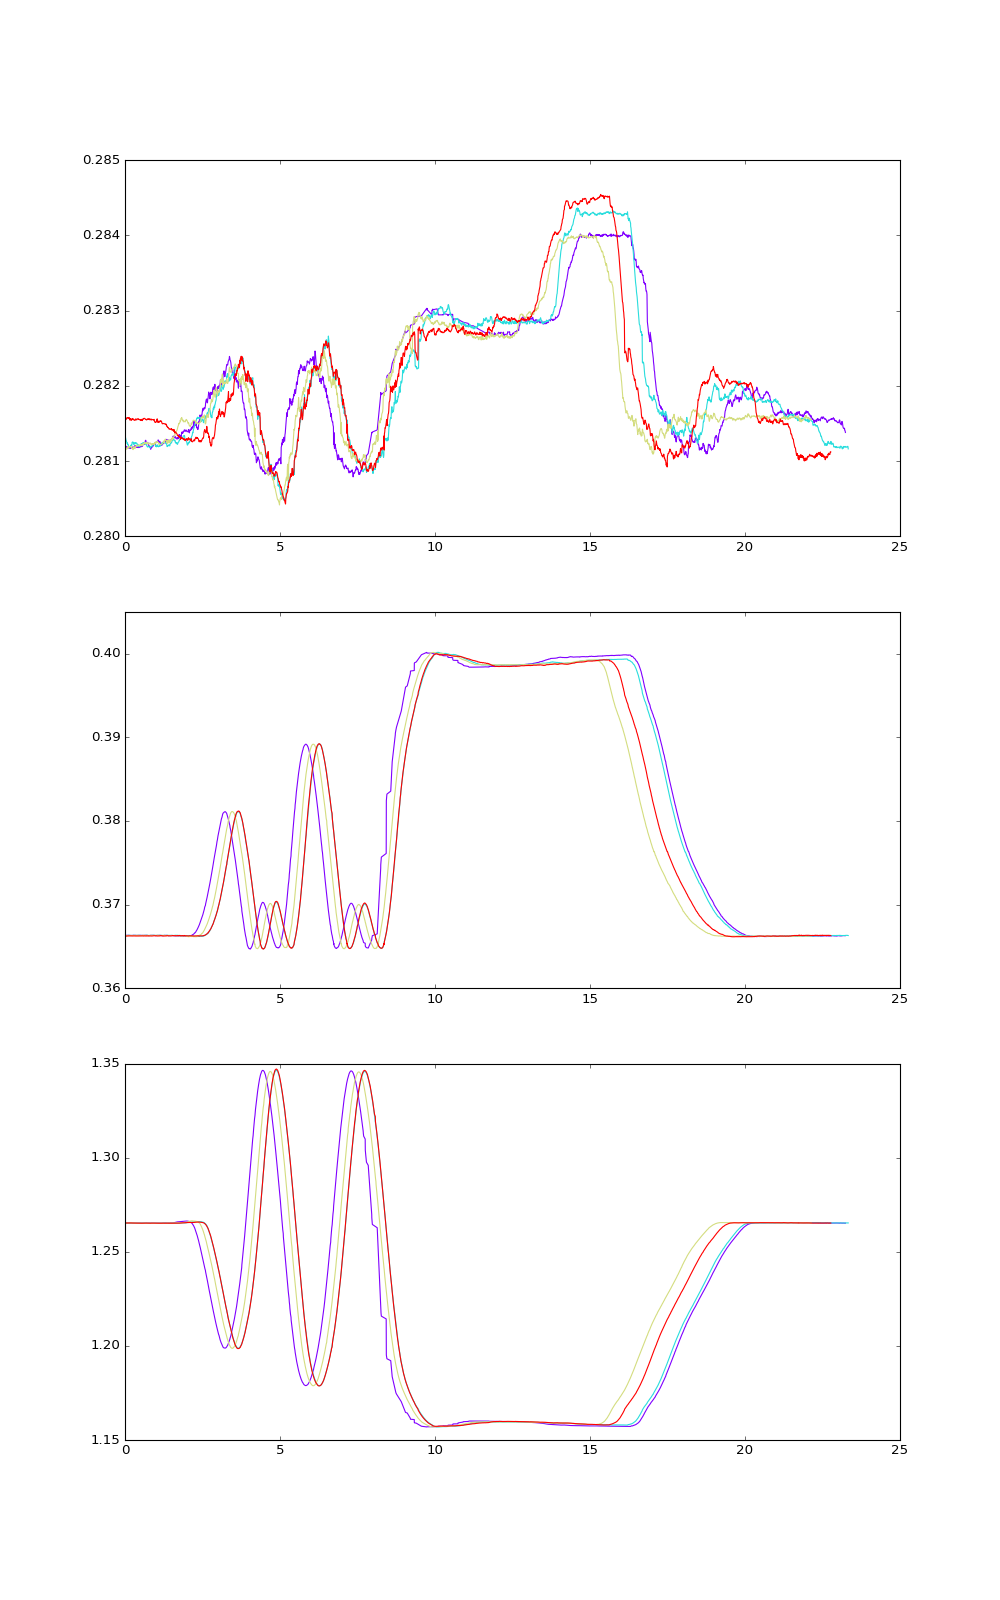

In [27]:
fig_vicon_raw = plotSegmentedRaw(
    data=vicon_pos_seg[bag1key]['j3'], 
    time=vicon_times_seg[bag1key]['j3'],
    topic='none'
)
fig_vicon_raw.set_size_inches(12.5, 20, forward=True)

[[0.28171162 0.36620497 1.2654952 ]
 [0.28168011 0.36621221 1.26548367]
 [0.28169127 0.36623546 1.26549204]
 ...
 [0.28155942 0.36625203 1.26543022]
 [0.28157692 0.36626879 1.26541466]
 [0.28157287 0.36627805 1.26540672]]


<IPython.core.display.Javascript object>


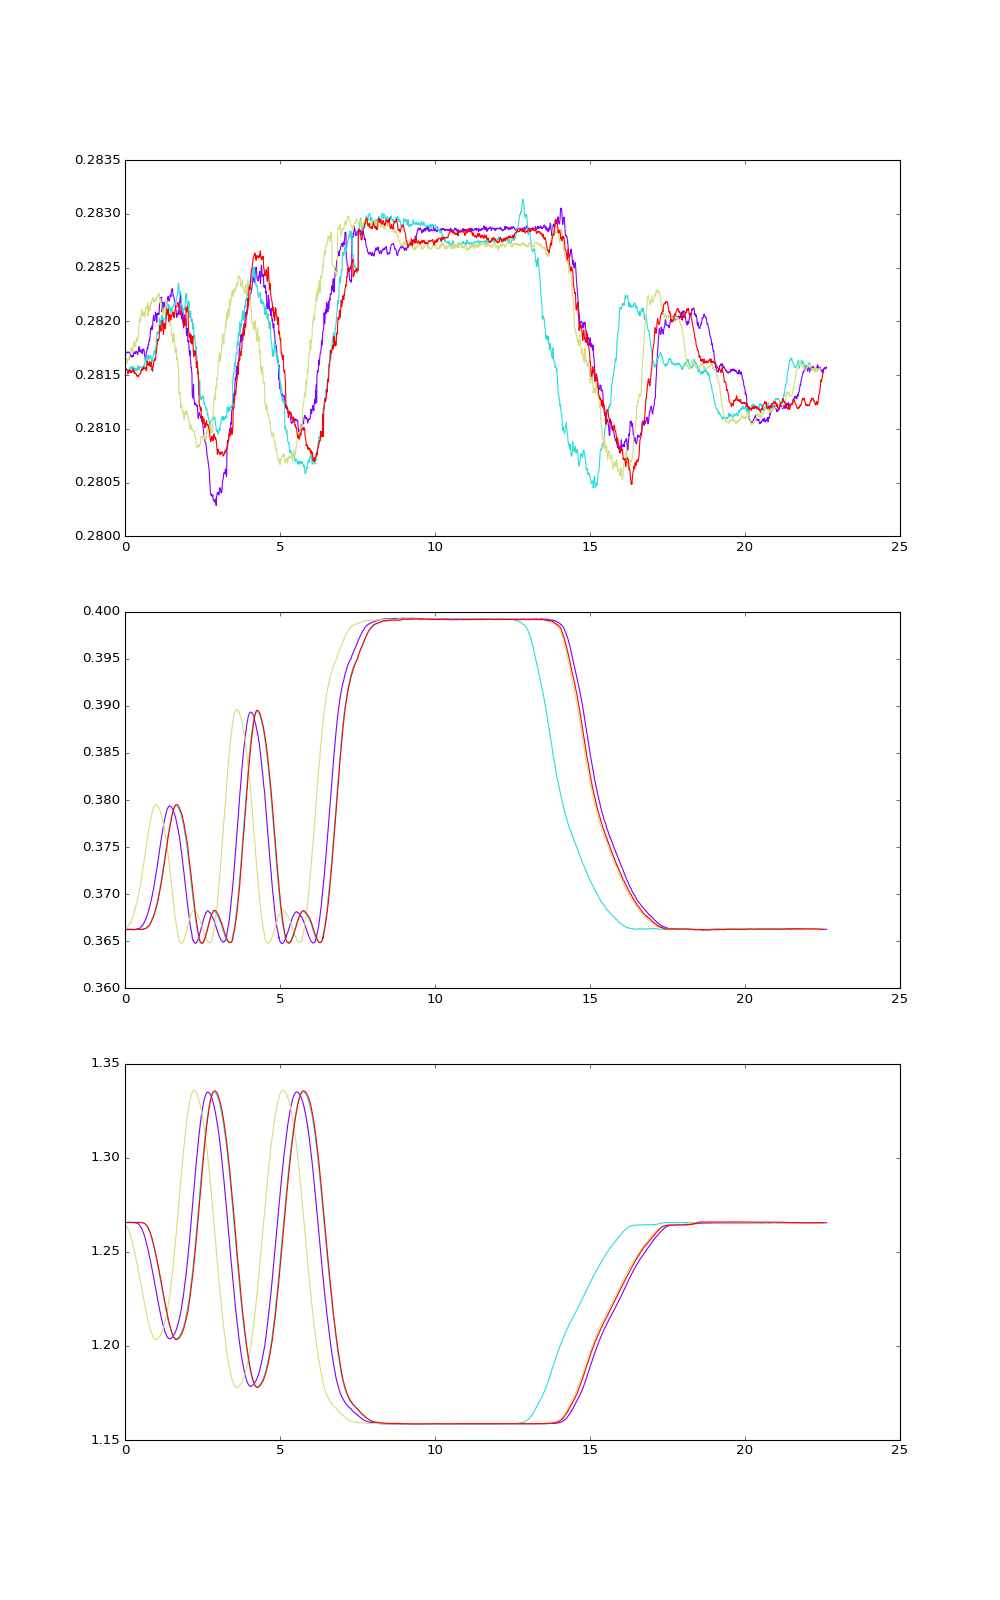

In [19]:
fig2_vicon_raw = plotSegmentedRaw(
    data=vicon_pos_seg[bag2key]['j3'], 
    time=vicon_times_seg[bag2key]['j3'],
    topic='none'
)
fig2_vicon_raw.set_size_inches(12.5, 20, forward=True)

<IPython.core.display.Javascript object>


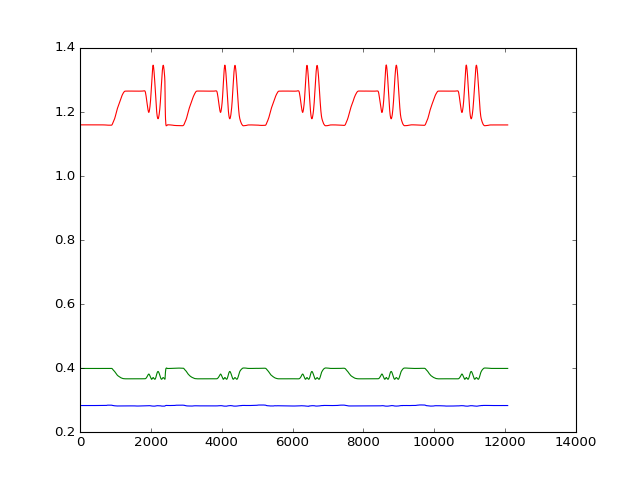

In [20]:
plt.figure()
plt.plot(vicon_pos[bag1key]['j3'])
plt.show()

<IPython.core.display.Javascript object>


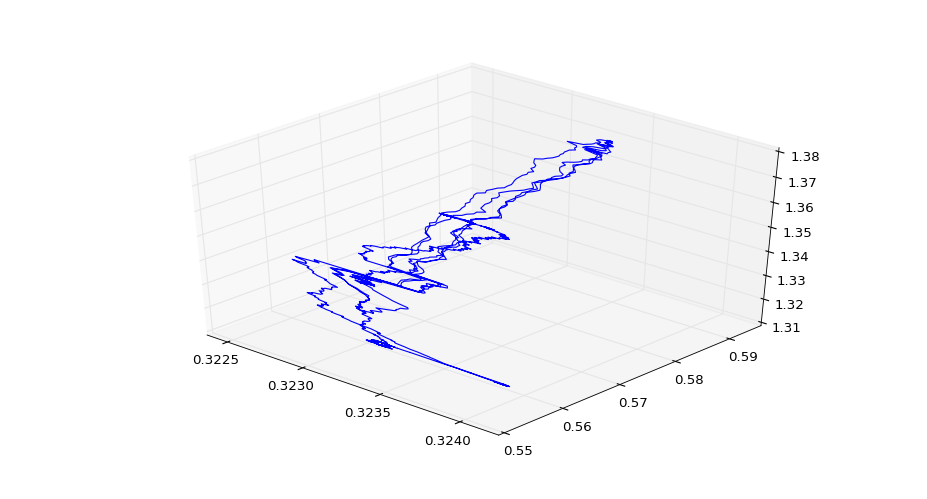

In [42]:
traj_fig = plot3DViconPosition(vicon_pos_seg[bag1key]['j2'][1])

In [ ]:
#############################

<IPython.core.display.Javascript object>


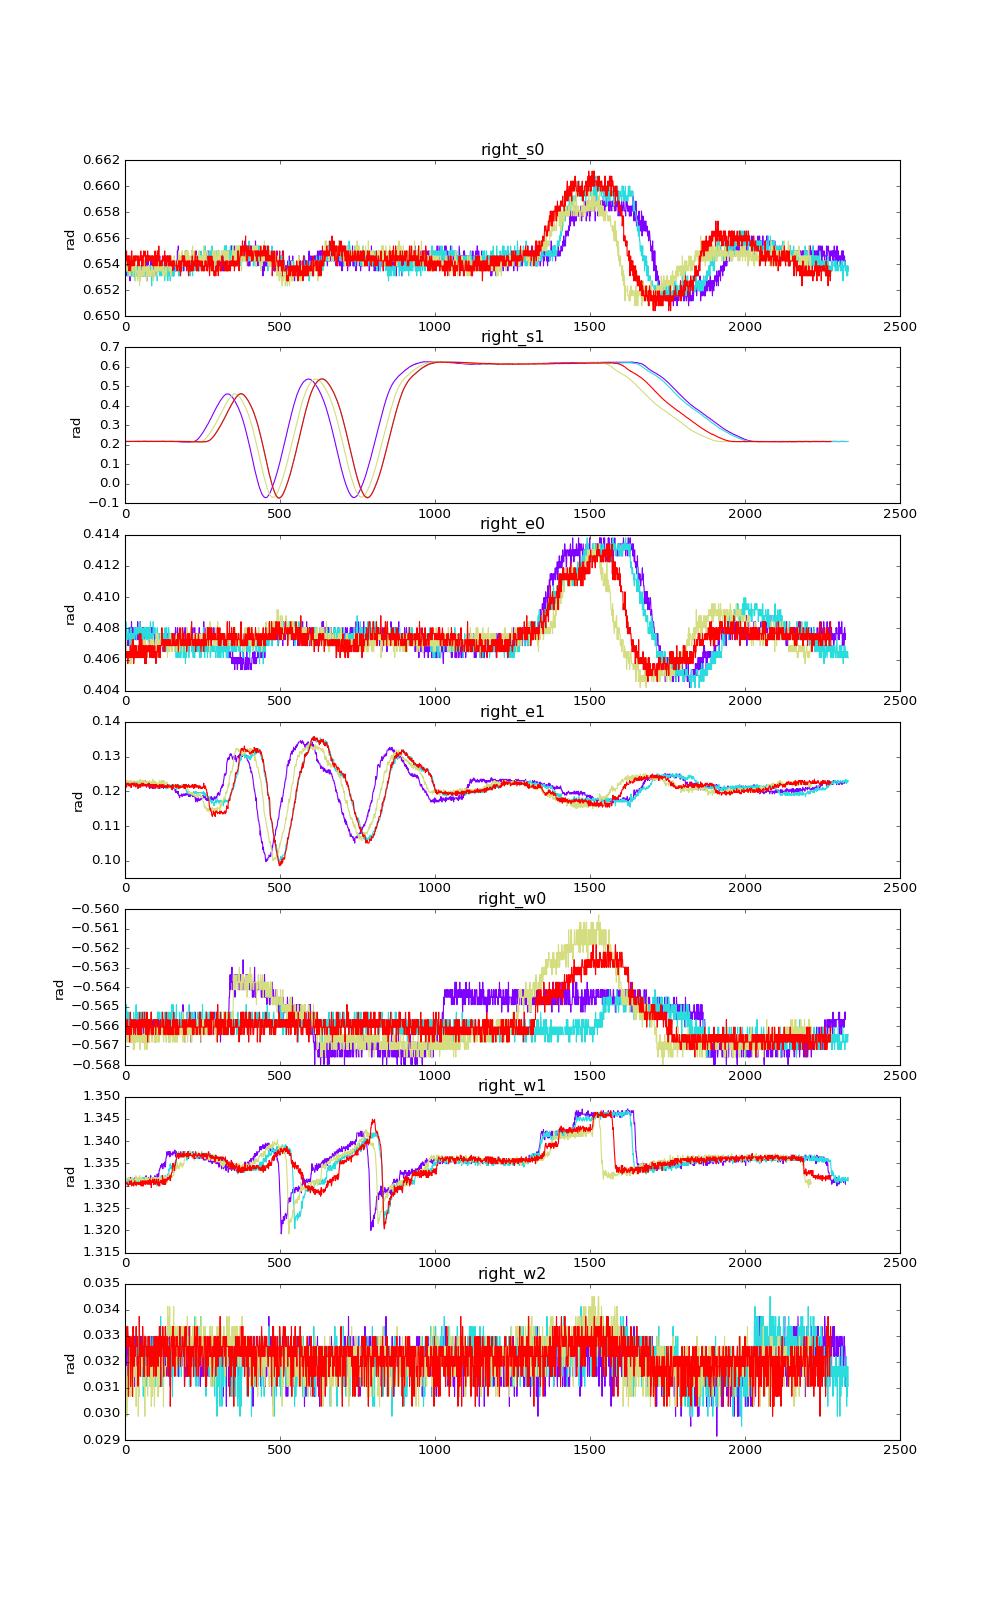

In [27]:
%matplotlib notebook

fig1_raw = plotSegmentedJoints(data_full=r_angles[bag1key], time_full=r_times[bag1key], joint_list=right_joints, data_type='angles')
fig1_raw.set_size_inches(12.5, 20, forward=True)



# plotSegmentedRaw(r_angles[bag1key][right_joints[i]], r_times[bag1key][right_joints[i]], 'test')
# plt.close()

<IPython.core.display.Javascript object>


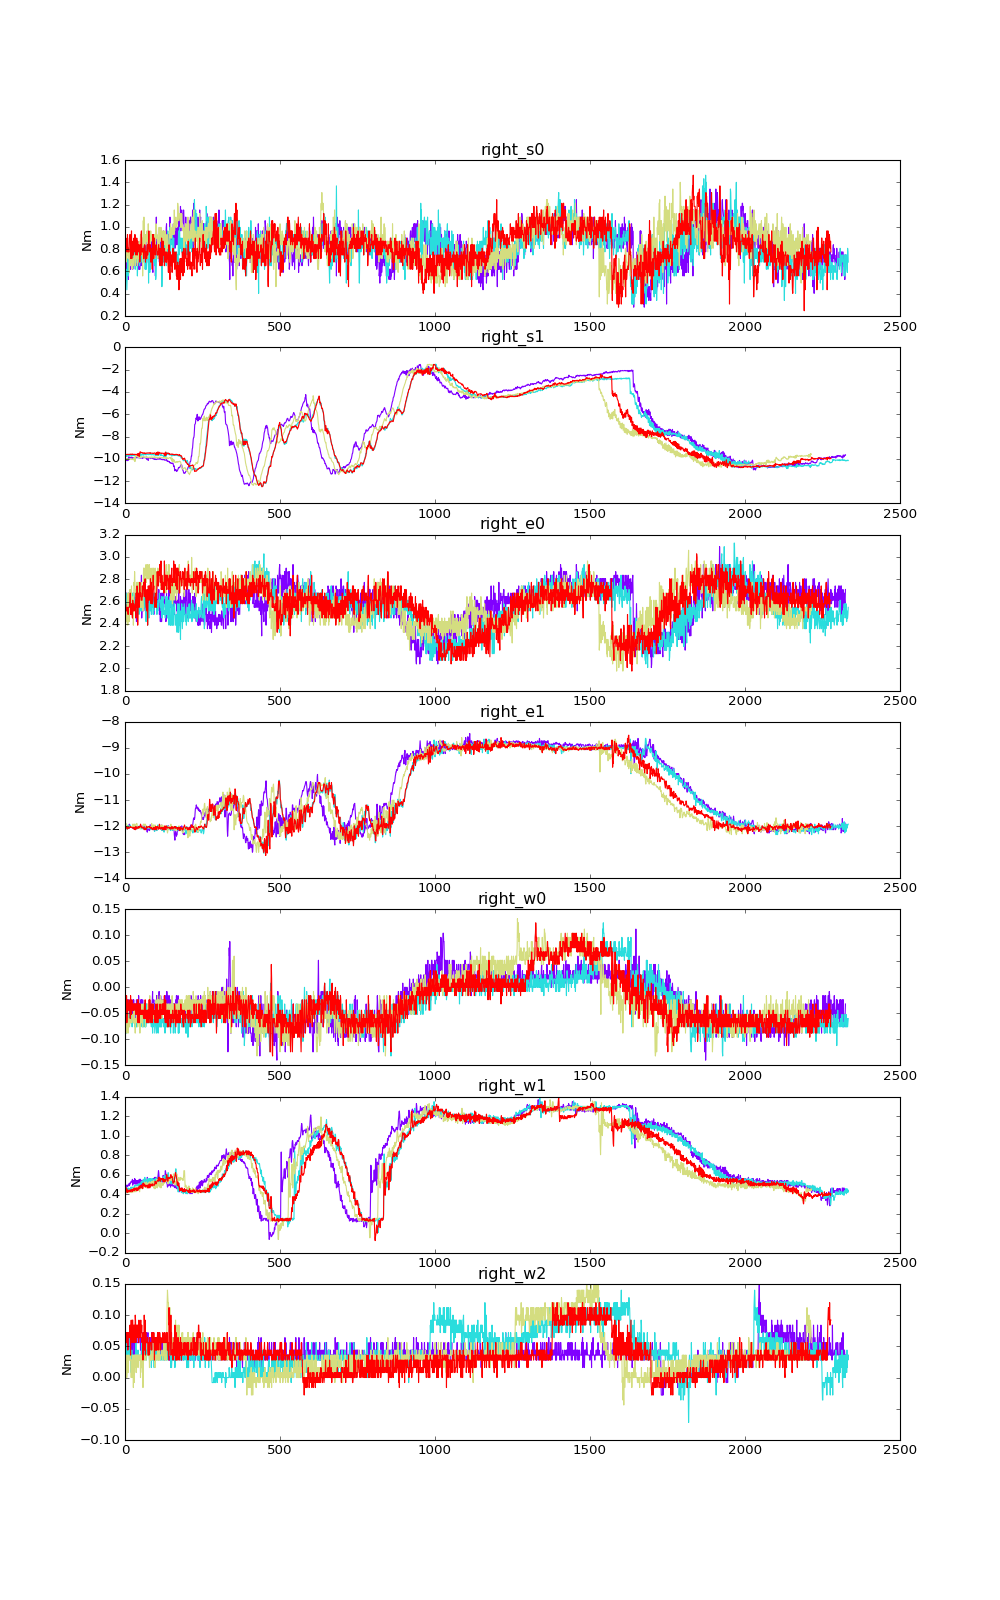

In [27]:
fig2_raw = plotSegmentedJoints(data_full=r_torques[bag1key], time_full=r_times[bag1key], joint_list=right_joints, data_type='torque')
fig2_raw.set_size_inches(12.5, 20, forward=True)

In [91]:
# r_angles_shifted, r_torques_shifted, l_angles_shifted, l_torques_shifted = {},{},{},{}
# r_times_shifted, l_times_shifted = {},{}

print right_joints

r_angles_shifted[bag1key], r_times_shifted[bag1key] = (
    shiftJointSignals(
        data_full=r_angles[bag1key], 
        time_full=r_times[bag1key],
        joint_list=right_joints)
)

r_torques_shifted[bag1key], r_times_shifted[bag1key] = (
    shiftJointSignals(
        data_full=r_torques[bag1key], 
        time_full=r_times[bag1key],
        joint_list=right_joints)
)

# shifted_joint_torques_seg, shifted_joint_times_seg = shiftSignals(joint_torques_seg, joint_times_seg)
# for i in range(len(shifted_joint_torques_seg)):
#     print len(shifted_joint_torques_seg[i]), len(shifted_joint_times_seg[i])
    


['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']
0
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
decreasing...
dec

<IPython.core.display.Javascript object>


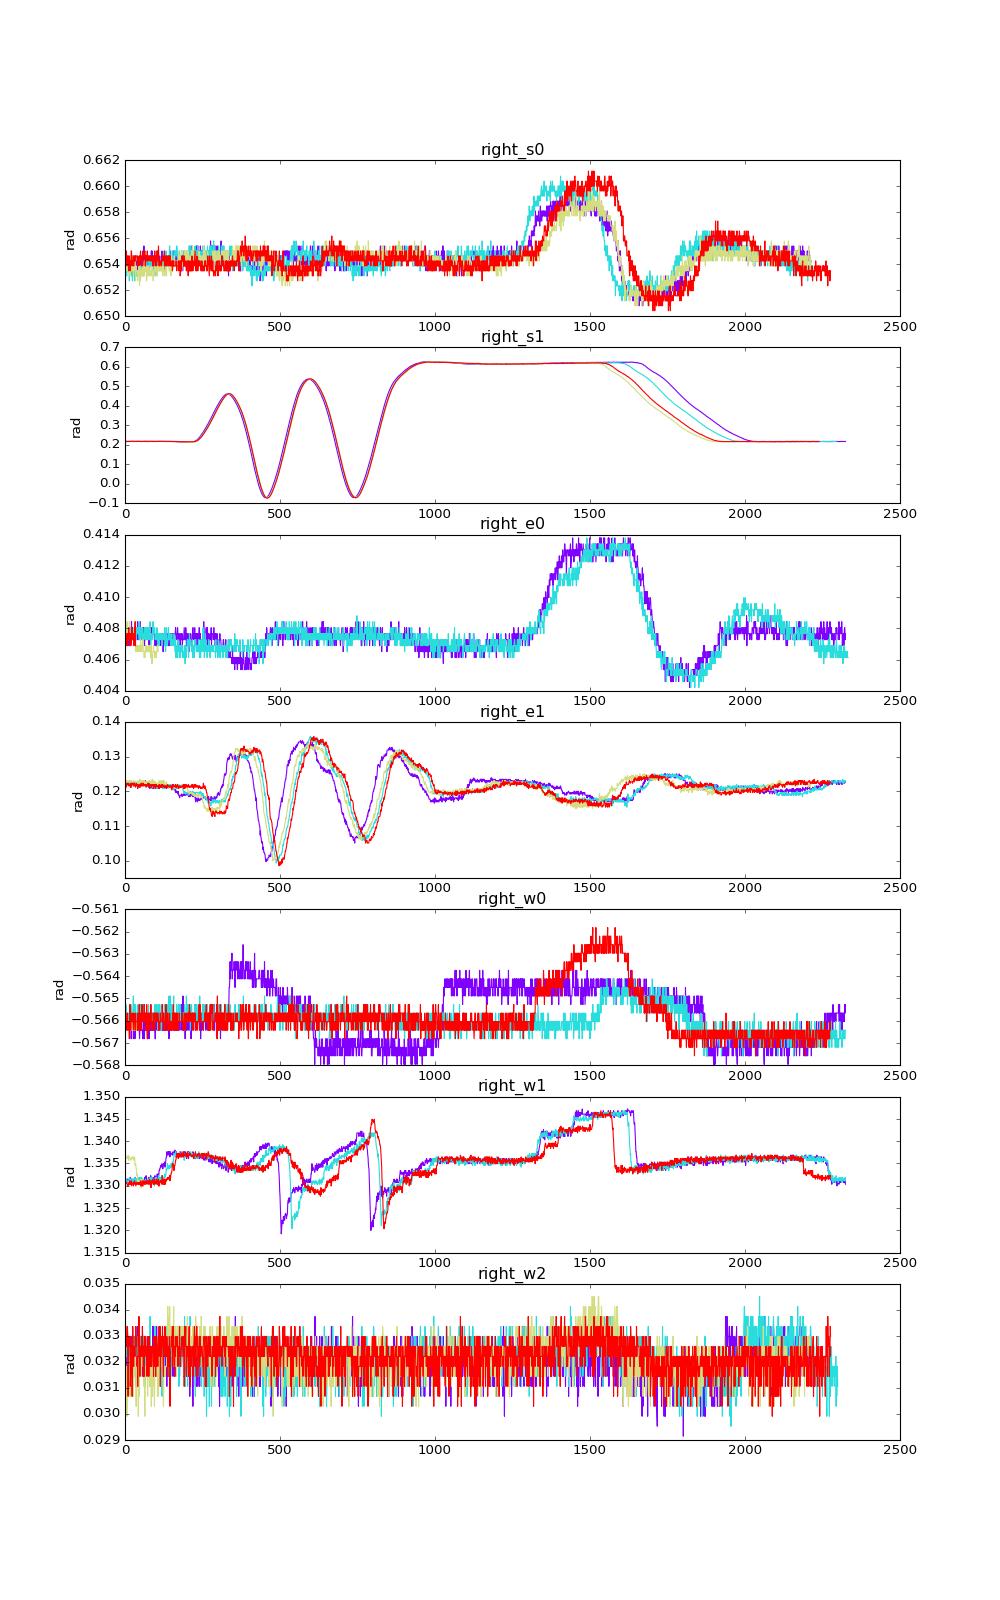

In [92]:
fig1_shift = plotSegmentedJoints(data_full=r_angles_shifted[bag1key], time_full=r_times_shifted[bag1key], joint_list=right_joints, data_type='angles')
fig1_shift.set_size_inches(12.5, 20, forward=True)
# plt.close()

<IPython.core.display.Javascript object>


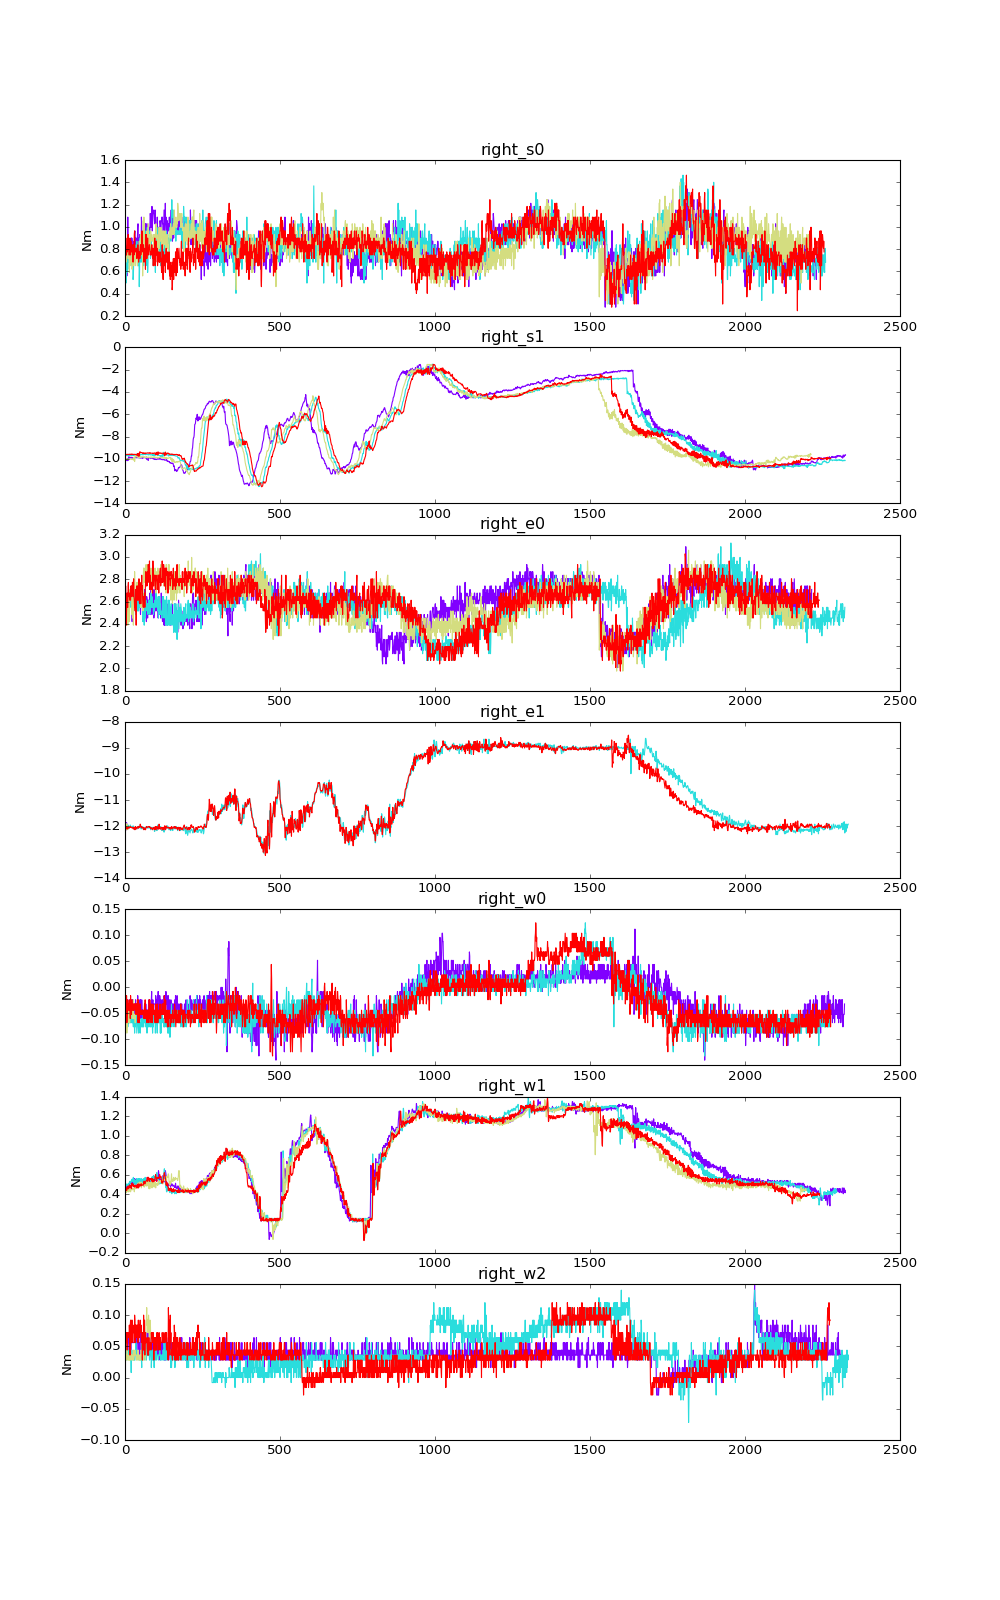

In [93]:
fig2_shift = plotSegmentedJoints(data_full=r_torques_shifted[bag1key], time_full=r_times_shifted[bag1key], joint_list=right_joints, data_type='torques')
fig2_shift.set_size_inches(12.5, 20, forward=True)

In [60]:
vicon_pos_shifted, vicon_rot_shifted, vicon_times_shifted = {},{},{}

for bag_ind in bag_keys:
    vicon_pos_shifted[bag_ind], vicon_rot_shifted[bag_ind], vicon_times_shifted[bag_ind] = {}, {}, {}
    for link in right_links:
        vicon_pos_shifted[bag_ind][link], vicon_rot_shifted[bag_ind][link], vicon_times_shifted[bag_ind][link] = {}, {}, {}
        for coord_pos in ['x','y','z']:
            vicon_pos_shifted[bag_ind][link][coord_pos] = {}
        for coord_rot in ['w', 'x','y','z']:
            vicon_pos_shifted[bag_ind][link][coord_rot] = {}


for bag_ind in bag_keys:
    for link_ind in right_links:
        for coord_pos in ['x','y','z']:
            vicon_pos_shifted[bag_ind][link_ind][coord_pos], vicon_times_shifted[bag_ind][link_ind] = (
                shiftSignals(
                    data=vicon_pos_sep_seg[bag_ind][link_ind][coord_pos], 
                    time=vicon_times_seg[bag_ind][link_ind]
            ))

#         for coord_rot in ['w', 'x', 'y', 'z']:
#             vicon_rot_shifted[bag_ind][link_ind][coord_rot], vicon_times_shifted[bag_ind][link_ind] = (
#                 shiftSignals(
#                     data=vicon_rot_sep_seg[bag_ind][link_ind][coord_rot], 
#                     time=vicon_times_seg[bag_ind][link_ind]
#             ))

most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
3
most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
0
most left shifted cycle:
1
most left shifted cycle:
1
most left shifted cycle:
0
most left shifted cycle:
1
most left shifted cycle:
2
most left shifted cycle:
2
most left shifted cycle:
0
most left shifted cycle:
2
most left shifted cycle:
2


[0.5722026  0.57221089 0.5722036  ... 0.57220798 0.57221159 0.57222315]


<IPython.core.display.Javascript object>


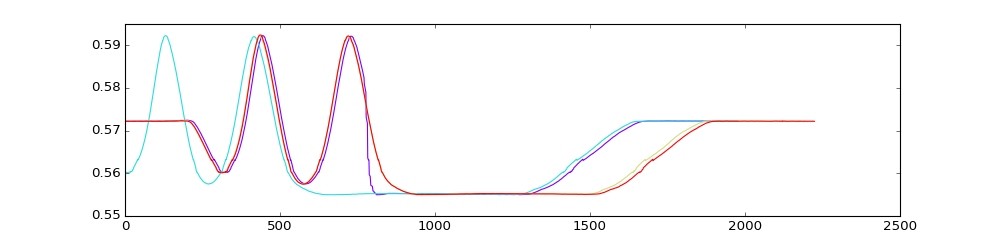

[0.57229798 0.57229604 0.57227668 ... 0.57225606 0.5722595  0.57227384]


<IPython.core.display.Javascript object>


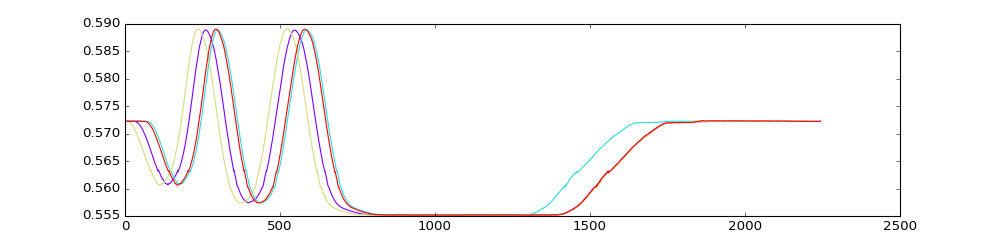

In [85]:
fig_vicon_shifted_1 = plotSegmentedSeparated(
    data=vicon_pos_shifted[bag1key]['j2']['y'], 
    time=vicon_times_shifted[bag1key]['j2'],
    topic='none'
)
fig_vicon_shifted_1.set_size_inches(12.5, 3, forward=True)

fig_vicon_shifted_2 = plotSegmentedSeparated(
    data=vicon_pos_shifted[bag2key]['j2']['y'], 
    time=vicon_times_shifted[bag2key]['j2'],
    topic='none'
)
fig_vicon_shifted_2.set_size_inches(12.5, 3, forward=True)

In [ ]:
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

#import R objects and dtw library functions
R = rpy2.robjects.r
DTW = importr('dtw')

In [ ]:
#save data nicely
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_angles', joint_angles, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_torques', joint_torques, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_times', joint_times, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_angles_segmented', joint_angles_seg, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/joint_times_segmented', joint_times_seg, allow_pickle=True)
# np.save('/home/anthony/ros_ws/src/baxter_experiments/pickled_vars/shifted_joint_angles_segmented', shifted_joint_angles_seg, allow_pickle=True)


In [32]:
# print len(r_angles[bag1key]['right_s1'][0])
print r_angles[bag1key]['right_s1']
print r_torques[bag1key]['right_s1']
print r_times[bag1key]['right_s1']

[array([0.21705828, 0.21705828, 0.21744178, ..., 0.21744178, 0.21820877,
       0.21744178]), array([0.21705828, 0.21705828, 0.21744178, ..., 0.21782527, 0.21782527,
       0.21782527]), array([0.21744178, 0.21667479, 0.21782527, ..., 0.21744178, 0.21705828,
       0.21705828]), array([0.21782527, 0.21744178, 0.21705828, ..., 0.21705828, 0.21744178,
       0.21744178])]
[array([-10.04 , -10.016, -10.04 , ...,  -9.704,  -9.624,  -9.652]), array([ -9.756,  -9.728,  -9.756, ..., -10.144, -10.172, -10.144]), array([ -9.964,  -9.964, -10.016, ...,  -9.52 ,  -9.6  ,  -9.6  ]), array([-9.624, -9.6  , -9.624, ..., -9.912, -9.988, -9.988])]
[array([0.00000000e+00, 1.00026131e-02, 1.99725628e-02, ...,
       2.32200069e+01, 2.32300026e+01, 2.32400038e+01]), array([0.00000000e+00, 1.00016594e-02, 2.00009346e-02, ...,
       2.33099971e+01, 2.33199985e+01, 2.33299792e+01]), array([0.00000000e+00, 1.00123882e-02, 1.99987888e-02, ...,
       2.21200011e+01, 2.21300008e+01, 2.21399777e+01]), array([0

In [ ]:
#prototype stuff here

# print j1_time[-1]
# print j2_time[-1]
# print j3_time[-1]
# print tf_time[-1]
# print traj_time[-1]
# print cycle_time[-1]
# print joint_times[-1]

# print j1_time[0]
# print j2_time[0]
# print j3_time[0]
# print tf_time[0]
# print traj_time[0]
# print cycle_time[0]
# print joint_times[0]


t0 = np.abs(np.correlate(test_data[12], test_data[0], 'full'))
t1 = np.abs(np.correlate(test_data[12], test_data[1], 'full'))

print len(test_data[12]), len(test_data[0]), len(test_data[1])
print t0
print t1
print np.argmax(t0)
print np.argmax(t1)
print len(t0)
print len(t1)
print len(t0) - np.argmax(t0)
print len(t1) - np.argmax(t1)

print np.argmax(t0) - len(test_data[12])
print np.argmax(t1) - len(test_data[12])

# plt.figure(2)
# plt.plot(test_data[12])
# plt.plot(test_data[0][:])
# plt.plot(test_data[1][:])
# plt.legend(['late (12)', '0', '1'])
# plt.show()

plt.figure(2)
plt.plot(test_data[12])
plt.plot(np.insert(test_data[0][:], 0, [test_data[0][0]]*522))
plt.plot(np.insert(test_data[1][:], 0, [test_data[0][0]]*470))
plt.legend(['late (12)', '0', '1'])
plt.show()

In [ ]:
# print df.columns
# print rosbag_pandas.get_bag_info('one_joint_one_bag.bag')
# print bag.read_messages(topics = '/tf')
num_msgs = 500
test_list = []
for topic, msg, t in bag1.read_messages(topics = ['/robot/joint_states']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

In [ ]:
num_msgs = 500
test_list = []
for topic, msg, t in bag.read_messages(topics = ['/board_pose/cycle_time']):
    if num_msgs < 1:
        break
    num_msgs -= 1
    print msg

In [4]:
positions_on = []
num_msgs = 50

for topic, msg, t in bag1.read_messages(topics = ['/gazebo/link_states']):
#         time = msg.transforms[1].header.stamp.to_sec()
#         frame_id = msg.transforms[1].header.frame_id

#         print frame_id
#     if num_msgs < 1:
#         break
    num_msgs -= 1
#     print(msg.pose[-3].position)
    positions_on.append([msg.pose[-3].position.x, msg.pose[-3].position.y, msg.pose[-3].position.z])
#     print msg.pose.position


In [5]:
positions_off = []
num_msgs = 50

for topic, msg, t in bag2.read_messages(topics = ['/gazebo/link_states']):
#         time = msg.transforms[1].header.stamp.to_sec()
#         frame_id = msg.transforms[1].header.frame_id

#         print frame_id
#     if num_msgs < 1:
#         break
    num_msgs -= 1
#     print(msg.pose[-3].position)
    positions_off.append([msg.pose[-3].position.x, msg.pose[-3].position.y, msg.pose[-3].position.z])

In [6]:
force_on = []
num_msgs=50

for topic, msg, t in bag1.read_messages(topics = ['/robot/limb/right/gravity_compensation_torques']):
#         time = msg.transforms[1].header.stamp.to_sec()
#         frame_id = msg.transforms[1].header.frame_id

#         print frame_id
#     if num_msgs < 1:
#         break
    num_msgs -= 1
#     print(msg)
    force_on.append(msg.actual_effort[1])

In [7]:
force_off = []
num_msgs=50

for topic, msg, t in bag2.read_messages(topics = ['/robot/limb/right/gravity_compensation_torques']):
#         time = msg.transforms[1].header.stamp.to_sec()
#         frame_id = msg.transforms[1].header.frame_id

#         print frame_id
#     if num_msgs < 1:
#         break
    num_msgs -= 1
#     print(msg)
    force_off.append(msg.actual_effort[1])

In [8]:
print(positions_on[0])

[0.32098516070736577, -0.2770045691803058, 0.501397637369649]


<IPython.core.display.Javascript object>


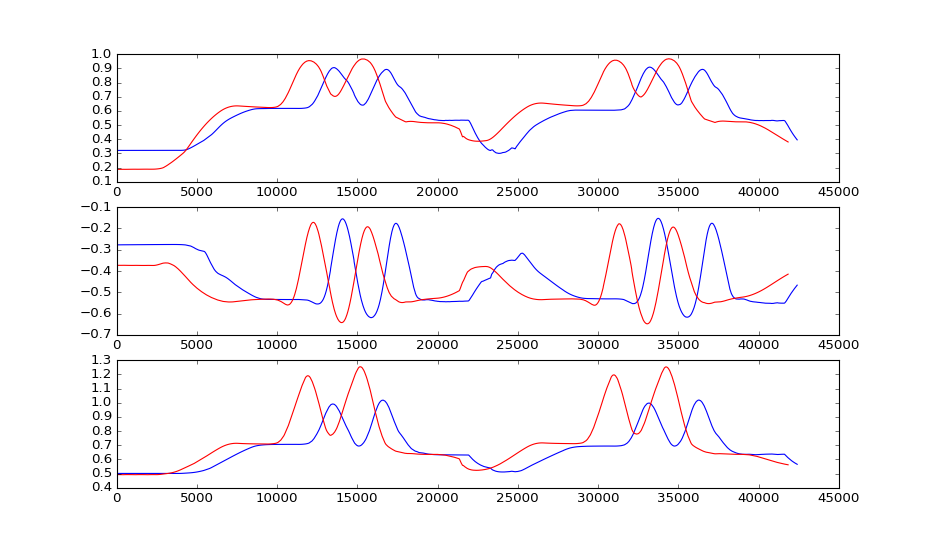

In [13]:
grav_fig_1 = plt.figure()
grav_fig_1.add_subplot(3, 1, 1)
plt.plot(np.array(positions_on)[:,0], color='b')
plt.plot(np.array(positions_off)[:,0], color='r')

grav_fig_1.add_subplot(3, 1, 2)
plt.plot(np.array(positions_on)[:,1], color='b')
plt.plot(np.array(positions_off)[:,1], color='r')

grav_fig_1.add_subplot(3,1,3)
plt.plot(np.array(positions_on)[:,2], color='b')
plt.plot(np.array(positions_off)[:,2], color='r')
plt.show()

<IPython.core.display.Javascript object>


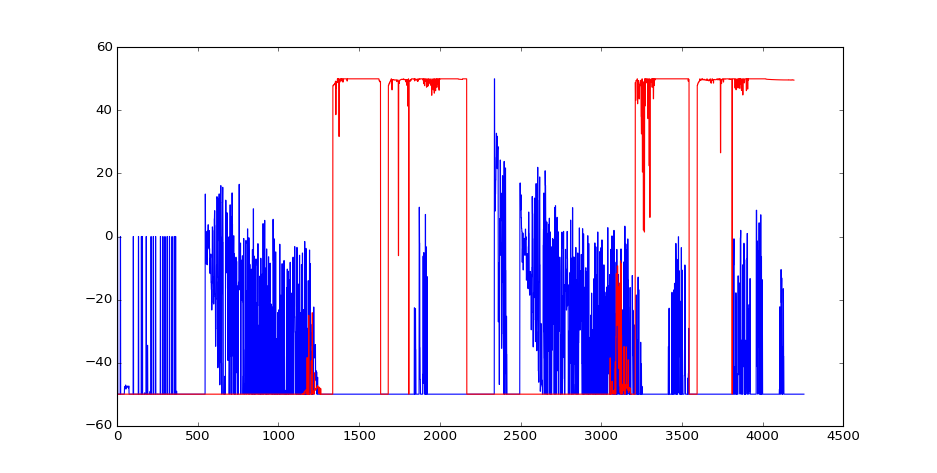

In [14]:
grav_fig_2 = plt.figure()
plt.plot(np.array(force_on)[:], color='b')
plt.plot(np.array(force_off)[:], color='r')
plt.show()